This file works primarily to query information about fume hood usage on campus. Calculating fume hood energy usage can be roughly simplified by the following formula:

BTU/hr = 1.08 * CFM * (Th-Tl)

CFM represents the cubic feet per minute of air passing through a fume hood. Th is the temperature of the room, Tl is the temperature of outdoors. We will update this script for fume hood energy usage during periods of cooling later.

In [5]:
import pandas as pd
import numpy as np
# import datetime
from datetime import datetime, timezone
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [2]:
def average(tups):
  tup_list = []
  for i in range(len(tups)):
    tup_list.append(tups[i][0])
  return np.mean(tup_list)

In [47]:
"""
Returns an array of tuples where tuple[0] is the metric, and tuple[1] is the time 
of measurement

Target: a WebCTRL point name in the form of a string 
Example: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log"

Server: a string representing the WebCTRL server our point exists in
Example: "biotech_main"

Start: the start time we wish to be querying data about (in string format)
Example: "2021-12-31T11:00Z"

End: The end time we wish to be querying data about
Example: "2022-12-31T11:00Z"
"""
def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server
          },
          "target": target
        }
      ],

    }
  resp = requests.post(url, json=data)
  # all data
  response_data = resp.json()
  # print(response_data)
  # data for a single target
  response_datum = response_data[0]
  # print(response_datum)
  # the target - e.g. "120MapleAve.STM.M22-V/AverageMassFlow"
  response_target = response_datum['target']
  # the metric for this target - e.g. "Steam"
  #response_metric = response_datum['metric']
  #print(response_metric)
  # the datapoints as a list of lists
  response_datapoints = response_datum['datapoints']
  # print(response_datapoints)
  # array of tuples for numpy
  tuple_array = [tuple(x) for x in response_datapoints]
  # make a numpy array
  npa = np.array(tuple_array, dtype=[('value', np.double), ('ts', 'datetime64[ms]')])
  # npa = npa.astype([('value', np.double), ('ts', datetime)])
  
  # print("here")
  # for index, i in enumerate(npa):
  #   j = pd.to_datetime(i[1]).replace(tzinfo=timezone.utc).astimezone(tz="America/New_York")
  #   npa[index][1] = j
  return npa


fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2022-12-25T00:00:00.000", end="2023-12-26T00:00:00.000")
# fume_query(target="#lstb_b-07_north/fh_sash_pos", server="weill_main", start="2022-10-22T11:00Z", end="2022-10-22T11:05Z")
# fume_query(target="#baker_west_lab_120/fh_sash_pos", server="endowed_main", start="2022-10-10T11:00Z", end="2022-10-22T11:05Z")

array([(1.1, '2022-12-25T05:00:00.000'), (1.1, '2022-12-25T05:05:00.000'),
       (1.1, '2022-12-25T05:10:00.000'), (1.1, '2022-12-25T05:15:00.000'),
       (1.1, '2022-12-25T05:20:00.000'), (1.1, '2022-12-25T05:25:00.000'),
       (1.1, '2022-12-25T05:30:00.000'), (1.1, '2022-12-25T05:35:00.000'),
       (1.1, '2022-12-25T05:40:00.000'), (1.1, '2022-12-25T05:45:00.000'),
       (1.1, '2022-12-25T05:50:00.000'), (1.1, '2022-12-25T05:55:00.000'),
       (1.1, '2022-12-25T06:00:00.000'), (1.1, '2022-12-25T06:05:00.000'),
       (1.1, '2022-12-25T06:10:00.000'), (1.1, '2022-12-25T06:15:00.000'),
       (1.1, '2022-12-25T06:20:00.000'), (1.1, '2022-12-25T06:25:00.000'),
       (1.1, '2022-12-25T06:30:00.000'), (1.1, '2022-12-25T06:35:00.000'),
       (1.1, '2022-12-25T06:40:00.000'), (1.1, '2022-12-25T06:45:00.000'),
       (1.1, '2022-12-25T06:50:00.000'), (1.1, '2022-12-25T06:55:00.000'),
       (1.1, '2022-12-25T07:00:00.000'), (1.1, '2022-12-25T07:05:00.000'),
       (1.1, '2022-12-25T

In [36]:
#print(fume_query("#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash","biotech_main","2022-10-10T10:00:00Z","2022-10-11T10:00:00Z" ))


"""
Returns a time series of the ithaca air temperature over the respective 
"""

def outside_temp(start,end):
  # https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query
  url = "https://portal-api.emcs.cucloud.net/query"
  target = "GameFarmRoadWeatherStation.TAVG_H_F"
  data = {
    "range": {
        "from": start,
        "to": end
    },
    "targets": [
        {
            "payload": {
                "additional": [
                    "metric",
                    "unit"
                ]
            },
            "target": target,
            "type": "timeseries"
        }
    ]
  }
  # POST the data to get the response from the API
  resp = requests.post(url, json=data)
  # all data
  response_data = resp.json()
  # data for a single target
  response_datum = response_data[0]
  # the target - e.g. "120MapleAve.STM.M22-V/AverageMassFlow"
  response_target = response_datum['target']
  #print(response_target)
  # the metric for this target - e.g. "Steam"
  response_metric = response_datum['metric']
  #print(response_metric)
  # the datapoints as a list of lists
  response_datapoints = response_datum['datapoints']
  # array of tuples for numpy
  tuple_array = [tuple(x) for x in response_datapoints]
  # make a numpy array
  npa = np.array(tuple_array, dtype=[('value', np.double), ('ts', 'datetime64[ms]')])
  return npa

2022-12-25 05:00:00    225.59
2022-12-25 05:05:00    222.66
2022-12-25 05:10:00    223.15
2022-12-25 05:15:00    225.59
2022-12-25 05:20:00    222.66
                        ...  
2022-12-26 20:30:00    222.17
2022-12-26 20:35:00    224.13
2022-12-26 20:40:00    221.20
2022-12-26 20:45:00    221.69
2022-12-26 20:50:00    224.62
Length: 479, dtype: float64
2022-12-25 05:00:00    0.0
2022-12-25 05:05:00    0.0
2022-12-25 05:10:00    0.0
2022-12-25 05:15:00    0.0
2022-12-25 05:20:00    0.0
                      ... 
2022-12-27 02:40:00    0.0
2022-12-27 02:45:00    0.0
2022-12-27 02:50:00    0.0
2022-12-27 02:55:00    0.0
2022-12-27 03:00:00    0.0
Length: 553, dtype: float64
2022-12-25 05:00:00    71.3
2022-12-25 05:05:00    71.3
2022-12-25 05:10:00    71.3
2022-12-25 05:15:00    71.3
2022-12-25 05:20:00    71.3
                       ... 
2022-12-26 20:30:00    74.2
2022-12-26 20:35:00    74.2
2022-12-26 20:40:00    74.1
2022-12-26 20:45:00    74.1
2022-12-26 20:50:00    74.1
Length: 4

,cfm,sash,occ,internal temp,external temp
2022-12-25 00:00:00,NaN,NaN,NaN,NaN,7.736
2022-12-25 01:00:00,NaN,NaN,NaN,NaN,8.042
2022-12-25 02:00:00,NaN,NaN,NaN,NaN,8.708
2022-12-25 03:00:00,NaN,NaN,NaN,NaN,9.050
2022-12-25 04:00:00,NaN,NaN,NaN,NaN,9.230
...,...,...,...,...,...
2022-12-27 02:40:00,NaN,NaN,0.0,NaN,NaN
2022-12-27 02:45:00,NaN,NaN,0.0,NaN,NaN
2022-12-27 02:50:00,NaN,NaN,0.0,NaN,NaN
2022-12-27 02:55:00,NaN,NaN,0.0,NaN,NaN


,cfm,sash,occ,internal temp,external temp
2022-12-25 05:00:00,225.59,1.1,0.0,71.3,8.8520
2022-12-25 06:00:00,225.59,1.1,0.0,71.3,9.0500
2022-12-25 07:00:00,225.10,1.1,0.0,71.3,9.8240
2022-12-25 08:00:00,224.62,1.1,0.0,71.3,10.4720
2022-12-25 09:00:00,224.62,1.1,0.0,71.2,11.4080
2022-12-25 10:00:00,225.10,1.1,0.0,71.3,12.5420
2022-12-25 11:00:00,224.62,1.1,0.0,71.4,13.1180
2022-12-25 12:00:00,224.62,1.1,0.0,71.3,13.7660
2022-12-25 13:00:00,224.62,1.1,0.0,71.4,14.3780
2022-12-25 14:00:00,224.62,1.1,0.0,71.7,14.7200


,cfm,sash,occ,internal temp,external temp,BTUh
2022-12-25 05:00:00,225.59,1.1,0.0,71.3,8.8520,15214.655866
2022-12-25 06:00:00,225.59,1.1,0.0,71.3,9.0500,15166.415700
2022-12-25 07:00:00,225.10,1.1,0.0,71.3,9.8240,14945.307408
2022-12-25 08:00:00,224.62,1.1,0.0,71.3,10.4720,14756.240189
2022-12-25 09:00:00,224.62,1.1,0.0,71.2,11.4080,14504.917363
2022-12-25 10:00:00,225.10,1.1,0.0,71.3,12.5420,14284.539864
2022-12-25 11:00:00,224.62,1.1,0.0,71.4,13.1180,14138.607067
2022-12-25 12:00:00,224.62,1.1,0.0,71.3,13.7660,13957.150046
2022-12-25 13:00:00,224.62,1.1,0.0,71.4,14.3780,13832.944171
2022-12-25 14:00:00,224.62,1.1,0.0,71.7,14.7200,13822.755408


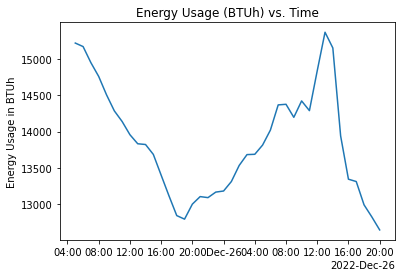

,cfm,sash,occ,internal temp,external temp,BTUh


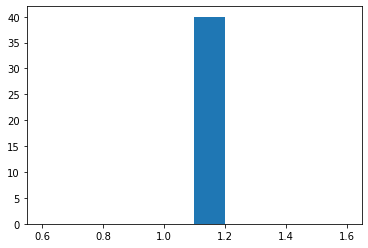

,cfm,sash,occ,internal temp,external temp,BTUh
2022-12-25 05:00:00,225.59,1.1,0.0,71.3,8.8520,15214.655866
2022-12-25 06:00:00,225.59,1.1,0.0,71.3,9.0500,15166.415700
2022-12-25 07:00:00,225.10,1.1,0.0,71.3,9.8240,14945.307408
2022-12-25 08:00:00,224.62,1.1,0.0,71.3,10.4720,14756.240189
2022-12-25 09:00:00,224.62,1.1,0.0,71.2,11.4080,14504.917363
2022-12-25 10:00:00,225.10,1.1,0.0,71.3,12.5420,14284.539864
2022-12-25 11:00:00,224.62,1.1,0.0,71.4,13.1180,14138.607067
2022-12-25 12:00:00,224.62,1.1,0.0,71.3,13.7660,13957.150046
2022-12-25 13:00:00,224.62,1.1,0.0,71.4,14.3780,13832.944171
2022-12-25 14:00:00,224.62,1.1,0.0,71.7,14.7200,13822.755408


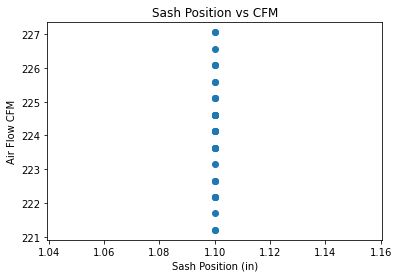

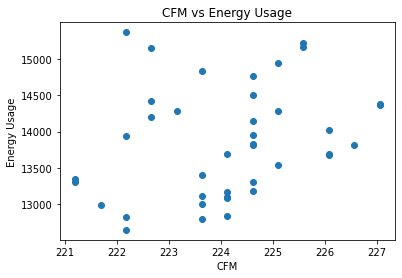

C:\Users\Dan\AppData\Local\Temp\ipykernel_15280\744664387.py:120: RankWarning: Polyfit may be poorly conditioned
  print(query(target_list,server,start,end))


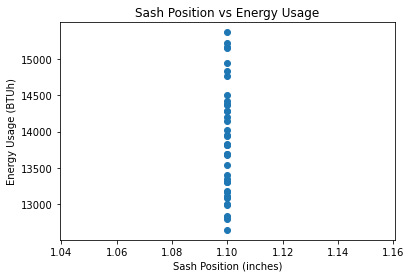

c:\Users\Dan\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)


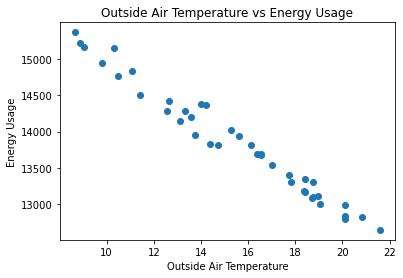

Variable: cfm(0.2620683708516871, 0.10234254166585567)
Variable: sash(nan, nan)
Variable: occ(-0.0696422117082228, 0.669373288335515)
Variable: internal temp(-0.6068774311793915, 3.301931053619997e-05)
Variable: external temp(-0.9862217588476405, 2.6431429298714954e-31)
Variable: BTUh(0.9999999999999998, 2.577066311792091e-293)
554160.62753712


In [54]:
from datetime import datetime
from dateutil import parser
import matplotlib.dates as mdates
"""
Requires:
target_list: A python list filled with target strings
len(target_list) = 3 
target_list[0] should represent the CFM target
target_list[1] should represent the internal air setpoint target
target_list[2] should represent the occupancy target
target_list[3] should represent the sash position 

server: the server where the target is stored (string)
start: start_time (string)
end: end_time (string)

Returns: Energy Usage by fumehood in btus over set target period
"""

def query(target_list,server, start,end):
  cfm_master = fume_query(target_list[0],server,start,end)
  occ_master = fume_query(target_list[2],server,start,end)
  internal_temp_master = fume_query(target_list[1],server,start,end)
  external_temp_master = outside_temp(start,end)
  sash_master = fume_query(target_list[3],server,start,end)


  cfm_list = pd.Series(data=[i[0] for i in cfm_master], index=[i[1] for i in cfm_master])
  occ_list = pd.Series(data=[i[0] for i in occ_master], index=[i[1] for i in occ_master])
  internal_temp_list = pd.Series(data=[i[0] for i in internal_temp_master], index=[i[1] for i in internal_temp_master])
  external_temp_list = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
  sash_list = pd.Series(data=[i[0] for i in sash_master], index=[i[1] for i in sash_master])
  print(cfm_list)
  print(occ_list)
  print(internal_temp_list)
  print(external_temp_list)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash" ,"occ", "internal temp", "external temp"]
  display(df)

  df = df.dropna()
  display(df)

  df["BTUh"] = 1.08 * df["cfm"] * (df["internal temp"] - df["external temp"])

  display(df)
  
  # convert_dates = np.vectorize(lambda s: parser.parse(s))
  # convert_dates(external_temp_list)

  # external_temp_list_resampled = pd.Series(data=external_temp_list, index=external_temp_list_dates).resample("5T").asfreq()
  # print(external_temp_list_resampled)

  # yourdate = parser.parse([i[1] for i in cfmMaster][0].astype(str))

  #We should try to do this in 10 minute intervals...not exactly sure how tho

  final_data = pd.Series(data=df["BTUh"], index=df.index)

  

  plt.plot(final_data)
  plt.ylabel("Energy Usage in BTUh")
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
  plt.title("Energy Usage (BTUh) vs. Time")
  plt.show()

  display(df[df["BTUh"]>20000])

  plt.hist(df["sash"])
  plt.show()

  display(df[(df["occ"] == 0) & (df["sash"] < 3)])

  plt.scatter(df["sash"], df["cfm"])
  plt.title("Sash Position vs CFM")
  plt.xlabel("Sash Position (in)")
  plt.ylabel("Air Flow CFM")
  plt.show()

  plt.scatter(df["cfm"],df["BTUh"])
  plt.title("CFM vs Energy Usage")
  plt.xlabel("CFM")
  plt.ylabel("Energy Usage")
  plt.show()

  plt.scatter(df["sash"],df["BTUh"])
  m, b = np.polyfit(df["sash"], df["BTUh"], 1)
  plt.plot(df["sash"], m*df["sash"] + b)
  plt.title("Sash Position vs Energy Usage")
  plt.xlabel("Sash Position (inches)")
  plt.ylabel("Energy Usage (BTUh)")
  plt.show()

  plt.scatter(df["external temp"],df["BTUh"])
  plt.title("Outside Air Temperature vs Energy Usage")
  plt.xlabel("Outside Air Temperature")
  plt.ylabel("Energy Usage")

  pearson_r = st.pearsonr(df["sash"],df["BTUh"])
  print(pearson_r)
  plt.show()
  ndf = (df[df["BTUh"]>12000])

  
  for val in df.columns :
    print("Variable: " + str(val) + str(st.pearsonr(df[val],df["BTUh"])))
  return final_data.sum()


target_list = ["#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash"]
server = "biotech_main"
start = "2022-12-25T00:00:00.000"
end = "2022-12-27T00:00:00.000"

print(query(target_list,server,start,end))